### 1. Import the datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torchvision.transforms as transforms
import torchvision

import torchvision.datasets as datasets # use to load the data from image folder
from torch.utils.data import Dataset, DataLoader # create iterator to iterate over the dataset

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.misc

In [3]:
# Define Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
project_dir = '/content/drive/My Drive/pix2pix'

In [5]:
# Define training and validation path

train_dir = os.path.join(project_dir, 'datasets', 'edges2shoes', 'train')
val_dir = os.path.join(project_dir, 'datasets', 'edges2shoes', 'val')

print(train_dir)

/content/drive/My Drive/pix2pix/datasets/edges2shoes/train


In [6]:
class CustomImageFolder(Dataset):
    def __init__(self, image_dir, transforms=None, sizes = None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_files = [x for x in os.listdir(self.image_dir) if self._is_image(x)]
        if not sizes is None:
          self.image_files = self.image_files[:sizes]
        
    def _is_image(self, filename):
        return any(filename.endswith(extension) 
                   for extension in ['.jpg', '.jpeg', '.png'])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.image_files[idx])).convert('RGB')
        img = np.array(img)
        image_a = img[:, :256, :]
        image_b = img[:, 256:, :]
        
        if self.transforms:
            image_a = self.transforms(image_a)
            image_b = self.transforms(image_b)
            
        return image_a, image_b
    
    

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.2

train_data = CustomImageFolder(train_dir, transforms=transform, sizes=2000)
test_data = CustomImageFolder(val_dir, transforms=transform)

# get total number of train data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


dataLoader = {
    'train': DataLoader(train_data, batch_size=16, sampler=train_sampler),
    'val': DataLoader(train_data, batch_size=16, sampler=valid_sampler),
    'test': DataLoader(test_data, batch_size=16, shuffle=False)
}

# dataset = {
#     'train' : CustomImageFolder(train_dir, transforms=transform, sizes=1000),
#     'val': CustomImageFolder(val_dir, transforms=transform, sizes=200),
# }

# dataLoader = {
#     'train': DataLoader(dataset['train'], shuffle=True, batch_size=16),
#     'val': DataLoader(dataset['val'], shuffle=False, batch_size=16),
# }


In [8]:
print(len(dataLoader['train']))
print(len(dataLoader['val']))

100
25


In [9]:
data = iter(dataLoader['train'])

In [10]:
a, b = data.next()

In [11]:
a.size()

torch.Size([16, 3, 256, 256])

In [12]:
b.size()

torch.Size([16, 3, 256, 256])

In [13]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [14]:
def to_data(x):
    """ Converts variable to numpy.
    """
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

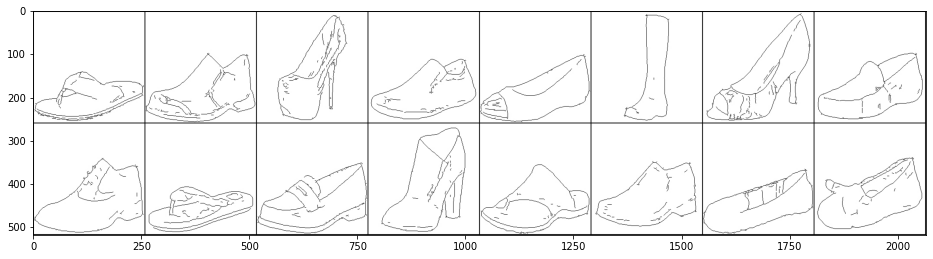

In [15]:
# plt.imshow(np.transpose(a[0], (1,2,0)));
img = torchvision.utils.make_grid(a)
npimg = img.numpy()
fig = plt.figure(figsize=(16, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)));

# plt.imshow(torchvision.utils.make_grid(np.transpose(npimg, (1, 2, 0))))

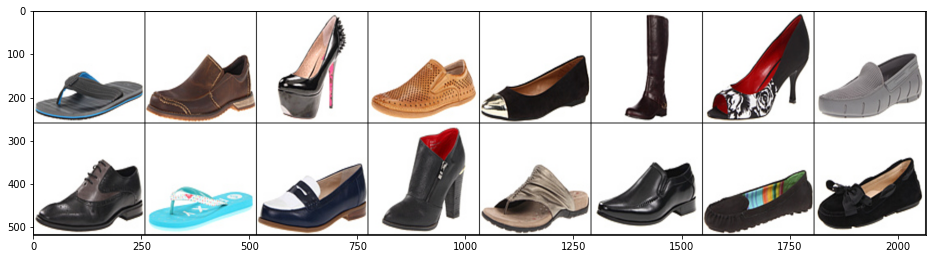

In [16]:
img = torchvision.utils.make_grid(b)
npimg = img.numpy()
fig = plt.figure(figsize=(16, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)));


### 2. Create Discriminator

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True):
    """Return sequence layer with Conv2D and BatchNormalization layer
    Params:
    in_channel: no. of input channel
    out_channel: no. of output channel
    kernel_size: kernel size of filter
    stride: stride of filter
    padding: pads the layer
    bias: create the bias weight
    batch_norm: create batch normalization layer
    
    return:
    nn.Sequence layer
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, 
                           out_channels=out_channels, 
                           kernel_size=kernel_size,
                           stride=stride, 
                           padding=padding, 
                           bias=bias)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)
    

In [19]:
class D_net(nn.Module):
    def __init__(self, conv_dim=64, kernel_size=4, stride=2, padding=1):
        super(D_net, self).__init__()
        
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.conv1 = conv(6, conv_dim, kernel_size, stride, padding, bias=True, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, kernel_size, stride, padding)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, kernel_size, stride, padding)
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, kernel_size, stride=1)
        self.conv5 = conv(conv_dim * 8, 1, kernel_size, stride=1)
        
        self.LeakyReLu = nn.LeakyReLU(0.2, True)
        
    def forward(self, x):
        output = self.LeakyReLu(self.conv1(x))
        output = self.LeakyReLu(self.conv2(output))
        output = self.LeakyReLu(self.conv3(output))
        output = self.LeakyReLu(self.conv4(output))
        output = torch.sigmoid(self.conv5(output))
        
        return output
        

In [20]:
input_size = (1, 6, 256, 256)
x = torch.empty(input_size).normal_(mean=0, std=0.5)


model = D_net()
out = model(x)

print(out.shape)

torch.Size([1, 1, 30, 30])


### 3. Generator

The Generator (G) consists of the Encoder, Residual and Decoder blocks. The Encoder blocks aim to downsample the image to extract low level feature. The Residual blocks aim to alleviate the peformance degratation issues when training the deeper Neural Network. Lastly, the Decoder blocks aim to upsample the data to generate the image.

The implementation of the Encoder is similar with the implementation of the conv in Discriminator. Therefore, the function conv() can re-apply in the Generator.

### Residual block

The basic building block of Residual block consists of two Convolutional Layers (with Batch Normalisation layer and ReLU). The Convolution layer uses kernel size=3, padding=1 and stride=1. The settings are aligned with the Residual block of CycleGAN.

In [21]:
class ResidualBlock(nn.Module):
    """ Residual Block also known as skip node
    """
    def __init__(self, conv_dim):
        """
        conv_dim - the input and output channels' size
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = conv(conv_dim, conv_dim,
                          kernel_size=3, stride=1, padding=1, batch_norm=True)
        self.conv2 = conv(conv_dim, conv_dim,
                          kernel_size=3, stride=1, padding=1, batch_norm=True)
    
    def forward(self, x):
        out_1 = F.relu(self.conv1(x))
        out_2 = x + self.conv2(out_1)
        return out_2
    

Running the Residual Block should return a tensor same size with the input tensor.

In [22]:
### Testing of the residual block
input_size = (2, 512, 1, 1)
x = torch.empty(input_size).normal_()

print(x.size())

res_block = ResidualBlock(512)
out = res_block(x)
print(out.size())


torch.Size([2, 512, 1, 1])
torch.Size([2, 512, 1, 1])


### Decoder block

The decoder reverses the operation of the Encoder. It consists of Conv2DTranspose, Batch Normalization and LeakyReLu layers.

In [23]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True):
    """ deconv - reverse the operation of conv
    Params:
    in_channel: no. of input channel
    out_channel: no. of output channel
    kernel_size: kernel size of filter
    stride: stride of filter
    padding: pads the layer
    bias: create the bias weight
    batch_norm: create batch normalization layer
    
    return:
    nn.Sequence layer
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                    stride=stride, padding=padding, bias=bias))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)


The deconv should return data with size of (n, 3, w, h) after a series of deconv. It upsamples the input data (n, 1, w, h) to (n, 3, w, h) in which the second parameters are color channels.

In [24]:
input_size = (2, 512, 1, 1)
x = torch.empty(input_size).normal_()

print(x.size())

filter_size = 64

d1 = deconv(filter_size * 8, filter_size * 8)
d2 = deconv(filter_size * 8, filter_size * 8)
d3 = deconv(filter_size * 8, filter_size * 8)
d4 = deconv(filter_size * 8, filter_size * 6)
d5 = deconv(filter_size * 6, filter_size * 4)
d6 = deconv(filter_size * 4, filter_size * 2)
d7 = deconv(filter_size * 2, filter_size)

d8 = nn.ConvTranspose2d(filter_size, 3, 4, 2, 1)

do1 = d1(x)
do2 = d2(do1)
do3 = d3(do2)
do4 = d4(do3)
do5 = d5(do4)
do6 = d6(do5)
do7 = d7(do6)
do8 = d8(do7)

print(do8.size())

torch.Size([2, 512, 1, 1])
torch.Size([2, 3, 256, 256])


### Generator

In [25]:
class Generator(nn.Module):
    """ Generator
    To Generate the image
    
    """
    def __init__(self, conv_dim=64, n_res_block=6):
        """ Initialize the Generator model. The model accepts data with depth of 3 (RGB)
        channels.
        
        conv_dim: Starting out channels
        n_res_block: no. of residual blocks
        """
        super(Generator, self).__init__()
        
        # Input image (256 x 256 x 3)
        self.conv1 = conv(3, conv_dim, bias=True, batch_norm=False) # 128 x 128 x 64
        self.conv2 = conv(conv_dim, conv_dim * 2) # 64 x 64 x 128
        self.conv3 = conv(conv_dim * 2, conv_dim * 4) # 32 x 32 x 256
        self.conv4 = conv(conv_dim * 4, conv_dim * 8) # 16 x 16 x 512
        self.conv5 = conv(conv_dim * 8, conv_dim * 8) # 8 x 8 x 512
        self.conv6 = conv(conv_dim * 8, conv_dim * 8) # 4 x 4 x 512
        self.conv7 = conv(conv_dim * 8, conv_dim * 8) # 2 x 2 x 512
        self.conv8 = conv(conv_dim * 8, conv_dim * 8) # 1 x 1 x 512
        
        res_layers = []
        for i in range(n_res_block):
            res_layers.append(ResidualBlock(conv_dim * 8))
            
        self.res_blocks = nn.Sequential(*res_layers)
        
        # 1 x 1 x 512
        self.deconv1 = deconv(conv_dim * 8, conv_dim * 8) # 2 x 2 x 512
        self.deconv2 = deconv(conv_dim * 8, conv_dim * 8) # 4 x 4 x 512
        self.deconv3 = deconv(conv_dim * 8, conv_dim * 8) # 8 x 8 x 512
        self.deconv4 = deconv(conv_dim * 8, conv_dim * 8) # 16 x16 x 512
        self.deconv5 = deconv(conv_dim * 8, conv_dim * 4) # 32 x 32 x 256
        self.deconv6 = deconv(conv_dim * 4, conv_dim * 2) # 64 x 64 x 128
        self.deconv7 = deconv(conv_dim * 2, conv_dim) # 128 x 128 x 64
        self.deconv8 = deconv(conv_dim, 3, batch_norm=False) # 256 x 256 x 3
        
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = F.leaky_relu(self.conv6(out), 0.2)
        out = F.leaky_relu(self.conv7(out), 0.2)
        out = F.leaky_relu(self.conv8(out), 0.2)
        
        out = self.res_blocks(out)
        
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        out = F.relu(self.deconv4(out))
        out = F.relu(self.deconv5(out))
        out = F.relu(self.deconv6(out))
        out = F.relu(self.deconv7(out))
        
        out = torch.tanh(self.deconv8(out))
        
        return out
    
    

The Generator should return the same size as input.

In [26]:
Gx = Generator()

input_size = (5, 3, 256, 256)
x = torch.empty(input_size).normal_()
print("x size:", x.size())

out = Gx(x)
print("Gx size:", out.size())


x size: torch.Size([5, 3, 256, 256])
Gx size: torch.Size([5, 3, 256, 256])


### Weights Initialization

In [27]:
### Initial weight of the model
def weights_init_normal(m):
    classname = m.__class__.__name__
    if(classname.find('Linear') != -1 or
      classname.find('Conv') != -1):
        m.weight.data.normal_(0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0)
            
    if(classname.find('BatchNorm2d') != -1):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

In [28]:
model.apply(weights_init_normal)

D_net(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (LeakyReLu): LeakyReLU(negative_slope=0.2, inplace=True)
)

### Create the Discriminator and Generator

Using the classes defined earlier, a new function is defined to return the both Discriminator and Generator.

In [29]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=9):
    """ Builds the Discriminator and Generator model
    
    Params
    ------
    g_conv_dim: Default starting convolution dimension of Generator
    d_conv_dim: Default starting convolution dimension of Discriminator
    n_res_blocks: No. of residual block applies
    
    Return
    ------
    Disrciminator, Generator
    
    """
    G_X = Generator(conv_dim=g_conv_dim, n_res_block=n_res_blocks)
    G_X.apply(weights_init_normal)
    
    D_X = D_net(conv_dim=d_conv_dim)
    D_X.apply(weights_init_normal)
    
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_X.to(device)
        D_X.to(device)
        print('Models moved to GPU.')
    else:
        print('Models moved to CPU.')
    
    return D_X, G_X



In [30]:
# Create the models
D_X, G_X = create_model()

Models moved to GPU.


In [31]:
print("------------------DX----------------------")
print(D_X)
print()
print("------------------GX----------------------")
print(G_X)

------------------DX----------------------
D_net(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (LeakyReLu): LeakyReLU(negat

### Define Loss Functions

In [32]:
def real_mse_loss(D_out):
    return torch.mean((D_out - 1) ** 2)

def fake_mse_loss(D_out):
    return torch.mean(D_out ** 2)

def l1_loss(fake, real, lamb = 100):
    loss = torch.mean(torch.abs(fake - real))
    return loss * lamb


### Optimizer

The existing study use Adam optimizer with learning rate=0.0002 and beta1=0.5 and beta2=0.999

In [33]:
import torch.optim as optim

# Create optimizer for the discriminator and Generator
lr=0.0002
# lr = 0.001
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(D_X.parameters(), lr, (beta1, beta2))
g_optimizer = optim.Adam(G_X.parameters(), lr, (beta1, beta2))


***
### Training

#### Scale function

The __tanh__ activation function of the generator produces the pixel values in range from -1 to 1. Therefore, it is needed to scale the image to a range of -1 and 1.

In [34]:
def scale(x, feature_range=(-1, 1)):
    """ Scale the input image X in to range
    of feature_range.
    
    This function assumes that the input x is
    already scale from 0-1.
    """
    
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [35]:
import pickle as pkl

num_epochs = 500
# print_every = len(dataLoader['train'])
print_every = 10
losses = []
samples = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_iter = iter(dataLoader['val'])
test_A, test_B = test_iter.next()   
test_A = scale(test_A[0])
test_B = scale(test_B[0]) 
test_A = test_A.to(device)
test_B = test_B.to(device)

for epoch in range(1, num_epochs + 1):
    for batch_i, (real_a, real_b) in enumerate(dataLoader['train']):
        # Get batch size
        batch_size = real_a.size(0)
        
        real_a = scale(real_a)
        real_b = scale(real_b)
        
        real_a = real_a.to(device)
        real_b = real_b.to(device)
        fake_b = G_X(real_a)
        
        # =====================================
        # Train Discriminator
        # =====================================
        d_optimizer.zero_grad()
        
        # Real Image
        real_ab = torch.cat((real_a, real_b), 1)
        D_real = D_X(real_ab)
        d_real_loss = real_mse_loss(D_real)
        
        # Fake Image
        fake_ab = torch.cat((real_a, fake_b), 1)
        D_fake = D_X(fake_ab)
        d_fake_loss = fake_mse_loss(D_fake)
        
        # Discriminator Loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward() # backpropagate
        d_optimizer.step() # update Discriminator's weights
        
        
        # =====================================
        # Train Generator
        # =====================================
        g_optimizer.zero_grad()
        
        # Get the loss of Generator
        # Always treat it is TRUE image when train the generator
        fake_Y = G_X(real_a)
        fake_ab = torch.cat((real_a, fake_Y), 1)
        out = D_X(fake_ab)
        g_d_loss = real_mse_loss(out)
        g_d_lloss = l1_loss(real_b, fake_Y)
        
        # Generator Loss
        g_loss = g_d_loss + g_d_lloss
        g_loss.backward() # backpropagate
        g_optimizer.step() # update Generator's weights
        
    ## EVALUATE THE GENERATOR After EACH EPOCH ##
    G_X.eval()
    with torch.no_grad():
      sample = G_X(torch.unsqueeze(test_A, 0))
      samples.append(sample)

      if (epoch + 1) % print_every == 0:
        losses.append((d_loss.item(), g_loss.item()))
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch + 1, 
                                                                               num_epochs,
                                                                               d_loss.item(),
                                                                               g_loss.item()))
    G_X.train()
    

    
# Save training generator samples
with open('/content/drive/My Drive/pix2pix/train_sample.pkl', 'wb') as f:
    pkl.dump(samples, f)


Epoch [   10/  500] | d_loss: 0.4640 | g_loss: 14.8292
Epoch [   20/  500] | d_loss: 0.4505 | g_loss: 13.6710
Epoch [   30/  500] | d_loss: 0.4375 | g_loss: 10.4706
Epoch [   40/  500] | d_loss: 0.4234 | g_loss: 10.9298
Epoch [   50/  500] | d_loss: 0.4068 | g_loss: 11.0514
Epoch [   60/  500] | d_loss: 0.4093 | g_loss: 8.4717
Epoch [   70/  500] | d_loss: 0.3838 | g_loss: 8.4752
Epoch [   80/  500] | d_loss: 0.3903 | g_loss: 8.1099
Epoch [   90/  500] | d_loss: 0.4240 | g_loss: 7.3956
Epoch [  100/  500] | d_loss: 0.3515 | g_loss: 6.6828
Epoch [  110/  500] | d_loss: 0.3457 | g_loss: 6.2836
Epoch [  120/  500] | d_loss: 0.4135 | g_loss: 6.6948
Epoch [  130/  500] | d_loss: 0.3235 | g_loss: 5.5189
Epoch [  140/  500] | d_loss: 0.3303 | g_loss: 4.7512
Epoch [  150/  500] | d_loss: 0.3446 | g_loss: 5.3194
Epoch [  160/  500] | d_loss: 0.3267 | g_loss: 4.9666
Epoch [  170/  500] | d_loss: 0.3440 | g_loss: 4.4867
Epoch [  180/  500] | d_loss: 0.3302 | g_loss: 4.4407
Epoch [  190/  500] | d

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


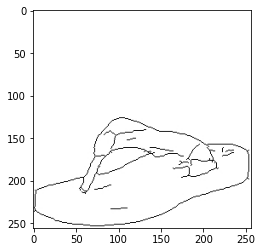

In [36]:
plt.imshow(np.transpose(to_data(test_A), (1,2,0)));

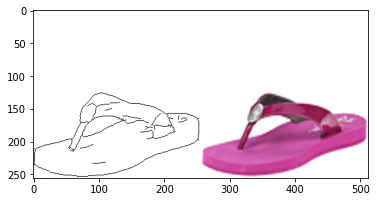

In [37]:
a = np.transpose(to_data(test_A), (1,2,0))
b = np.transpose(to_data(test_B), (1,2,0))

ab = np.hstack((a,b))
plt.imshow(ab);

In [38]:
def view_samples(samples, cols = 5):
    iteration = len(samples)
    rows = iteration // cols
    for i in range(0, iteration, cols):
        fig, axes = plt.subplots(1, cols, figsize=(16,8))
        for j in range(cols):
            img = np.transpose(to_data(samples[i+j].squeeze(0)), (1,2,0))
            axes[j].imshow(img)
            axes[j].set_axis_off()
    plt.show();

In [39]:
# view_samples(samples, 10)

In [40]:
test_iter = iter(dataLoader['val'])
test_A, test_B = test_iter.next() 

In [41]:
test_A.size()

torch.Size([16, 3, 256, 256])

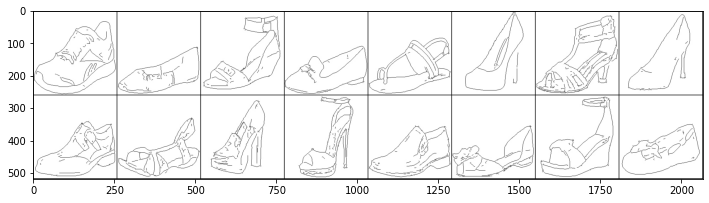

In [42]:

img = torchvision.utils.make_grid(test_A)
npimg = img.numpy()
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)));

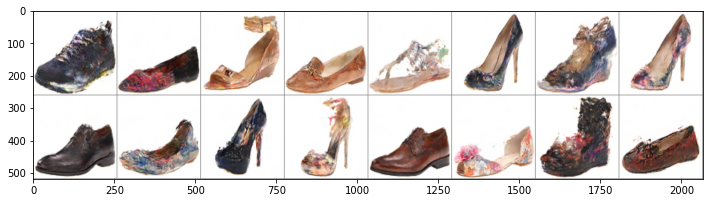

In [43]:
input_a = scale(test_A)

input_a = input_a.to(device)

out = G_X(input_a)
img = torchvision.utils.make_grid(out)
npimg = to_data(img.cpu().detach())
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)));


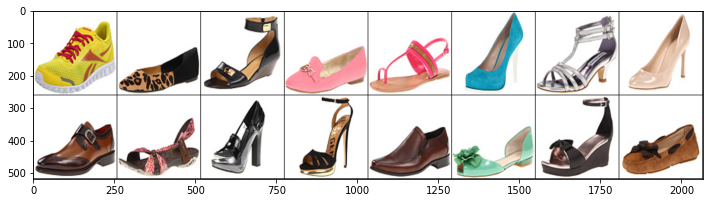

In [44]:
img = torchvision.utils.make_grid(test_B)
npimg = img.numpy()
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)));

In [45]:
model_save_path = os.path.join(project_dir, 'models.pth')

torch.save({
    'discriminator_state_dict': D_X.state_dict(),
    'generator_state_dict': G_X.state_dict(),
    'd_optimizer_state_dict': d_optimizer.state_dict(),
    'g_optimizer_state_dict': g_optimizer.state_dict(),
}, model_save_path)